In [12]:
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import config

In [13]:
from enum import Enum
class DFUData(Enum):
    L = 0 # Left Foot
    R = 1 # Right Foot
    L_LCA = 2  # Angiosom LCA Left Foot 
    R_LCA = 3  # Angiosom LCA Right Foot
    L_LPA = 4  # Angiosom LPA Left Foot 
    R_LPA = 5  # Angiosom LPA Right Foot 
    L_MCA = 6  # Angiosom MCA Left Foot 
    R_MCA = 7  # Angiosom MCA Right Foot 
    L_MPA = 8  # Angiosom MPA Left Foot 
    R_MPA = 9  # Angiosom MPA Right Foot 


class INAOEDataset():
    def __init__(self, root_path, dm_group = False):
        cg_path = os.path.join(root_path, 'Control Group')
        dm_path = os.path.join(root_path, 'DM Group')

        self.dm_group = dm_group

        self.cg_subjects = sorted(list(map(lambda x: os.path.join(cg_path, x), os.listdir(cg_path))))
        self.dm_subjects = sorted(list(map(lambda x: os.path.join(dm_path, x), os.listdir(dm_path))))

    def set_group(self, dm_group):
        self.dm_group = dm_group

    def __len__(self):
        if self.dm_group:
            return len(self.dm_subjects)
        
        return len(self.cg_subjects) 

    def get_subjects_names(self):
        dataset = self.dm_subjects if self.dm_group else self.cg_subjects
        return list(map(lambda x: os.path.basename(x), dataset))

    def get_subject(self, idx, data:DFUData):
        dataset = self.dm_subjects if self.dm_group else self.cg_subjects

        subject = os.path.basename(dataset[idx])
        path = os.path.join(dataset[idx], 'Angiosoms') if data.value > 1 else dataset[idx]
        return pd.read_csv(os.path.join(path, subject + '_' + data.name + '.csv'), header=None).astype('float32')

In [47]:
dm_group = False
save_path = 'data/DM' if dm_group else 'data/CG'

dataset = INAOEDataset(config.INAOE_DATASET_DIR, dm_group=True)

In [48]:
from scipy.stats import skew, kurtosis

def get_metrics(dataset, data:DFUData):
    subjects = dataset.get_subjects_names()
    mean_data = []
    std_data = []
    max_data = []
    min_data = []
    skew_data = []
    kurtosis_data = []
    metrics = []

    fulldata = None
    for idx in range(len(dataset)):
        # data = dataset.get_subject(idx, data).to_numpy()
        subject_data = dataset.get_subject(idx, data).to_numpy()
        subject_data = subject_data[subject_data>0.5] # Remove background
        mean_data.append(subject_data.mean())
        std_data.append(subject_data.std())
        max_data.append(subject_data.max())
        min_data.append(subject_data.min())
        skew_data.append(skew(subject_data))
        kurtosis_data.append(kurtosis(subject_data))

    metrics = {'Subject': subjects,
        '{}_mean'.format(data.name): mean_data, 
        '{}_std'.format(data.name): std_data,
        '{}_min'.format(data.name): min_data,
        '{}_max'.format(data.name): max_data,
        '{}_skew'.format(data.name): skew_data,
        '{}_kurtosis'.format(data.name): kurtosis_data}

    return pd.DataFrame(metrics)

## Qualitative Test

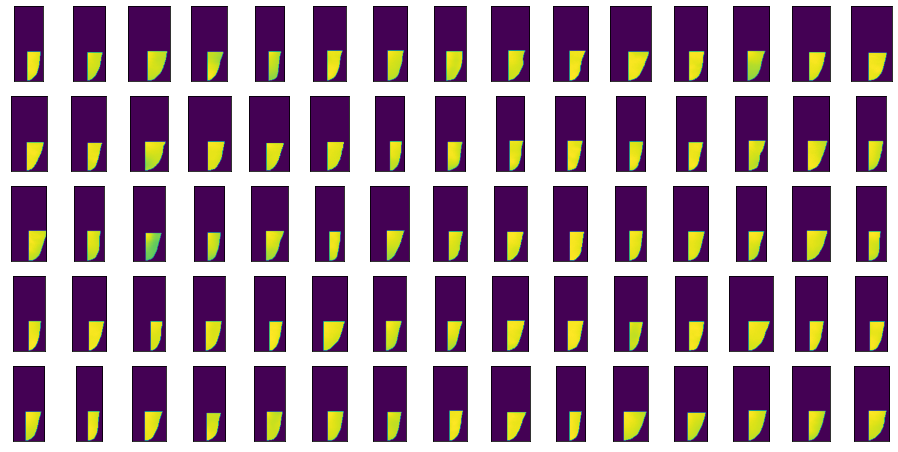

In [49]:
plt.figure(figsize=(16, 8))
for i in range(len(dataset)):
    plt.subplot(5, 15, i+1)
    data = dataset.get_subject(i, DFUData.L_LCA)
    plt.imshow(data.to_numpy())
    plt.xticks([])
    plt.yticks([])
    if i == (5*15)-1:
        break

plt.show()

# MPA

In [50]:
l_mpa_metrics = get_metrics(dataset, DFUData.L_MPA)
r_mpa_metrics = get_metrics(dataset, DFUData.R_MPA)

l_mpa_metrics.to_csv(os.path.join(save_path, 'MPA/L_MPA_metrics.csv'), index=False)
r_mpa_metrics.to_csv(os.path.join(save_path, 'MPA/R_MPA_metrics.csv'), index=False)

# LCA

In [51]:
l_lca_metrics = get_metrics(dataset, DFUData.L_LCA)
r_lca_metrics = get_metrics(dataset, DFUData.R_LCA)

l_lca_metrics.to_csv(os.path.join(save_path, 'LCA/L_LCA_metrics.csv'), index=False)
r_lca_metrics.to_csv(os.path.join(save_path, 'LCA/R_LCA_metrics.csv'), index=False)

# LPA

In [52]:
l_lpa_metrics = get_metrics(dataset, DFUData.L_LPA)
r_lpa_metrics = get_metrics(dataset, DFUData.R_LPA)

l_lpa_metrics.to_csv(os.path.join(save_path, 'LPA/L_LPA_metrics.csv'), index=False)
r_lpa_metrics.to_csv(os.path.join(save_path, 'LPA/R_LPA_metrics.csv'), index=False)

# MCA

In [53]:
l_mca_metrics = get_metrics(dataset, DFUData.L_MCA)
r_mca_metrics = get_metrics(dataset, DFUData.R_MCA)

l_mca_metrics.to_csv(os.path.join(save_path, 'MCA/L_MCA_metrics.csv'), index=False)
r_mca_metrics.to_csv(os.path.join(save_path, 'MCA/R_MCA_metrics.csv'), index=False)

# Merge

In [74]:
angiosoms = ['LCA', 'LPA', 'MCA', 'MPA']
metrics_df = None
for angiosom in angiosoms:
    l_metrics = pd.read_csv(os.path.join(save_path, angiosom, 'L_{}_metrics.csv'.format(angiosom)))
    r_metrics = pd.read_csv(os.path.join(save_path, angiosom, 'R_{}_metrics.csv'.format(angiosom)))

    # l_metrics['Side'] = 'Left'
    # r_metrics['Side'] = 'Right'

    angiosom_metrics = pd.merge(l_metrics, r_metrics, on='Subject')

    if metrics_df is None:
        metrics_df = angiosom_metrics
    else:
        metrics_df = pd.merge(metrics_df, angiosom_metrics, on='Subject')
    # print(metrics)


group = 'dm' if dm_group else 'cg'
metrics_df.to_csv(os.path.join(save_path, '{}_metrics.csv'.format(group)), index=False)

In [73]:
metrics_df.columns

Index(['Subject', 'L_LCA_mean', 'L_LCA_std', 'L_LCA_min', 'L_LCA_max',
       'L_LCA_skew', 'L_LCA_kurtosis', 'R_LCA_mean', 'R_LCA_std', 'R_LCA_min',
       'R_LCA_max', 'R_LCA_skew', 'R_LCA_kurtosis', 'L_LPA_mean', 'L_LPA_std',
       'L_LPA_min', 'L_LPA_max', 'L_LPA_skew', 'L_LPA_kurtosis', 'R_LPA_mean',
       'R_LPA_std', 'R_LPA_min', 'R_LPA_max', 'R_LPA_skew', 'R_LPA_kurtosis',
       'L_MCA_mean', 'L_MCA_std', 'L_MCA_min', 'L_MCA_max', 'L_MCA_skew',
       'L_MCA_kurtosis', 'R_MCA_mean', 'R_MCA_std', 'R_MCA_min', 'R_MCA_max',
       'R_MCA_skew', 'R_MCA_kurtosis', 'L_MPA_mean', 'L_MPA_std', 'L_MPA_min',
       'L_MPA_max', 'L_MPA_skew', 'L_MPA_kurtosis', 'R_MPA_mean', 'R_MPA_std',
       'R_MPA_min', 'R_MPA_max', 'R_MPA_skew', 'R_MPA_kurtosis'],
      dtype='object')

# Min - Max

In [78]:
min_column = ['L_LCA_min', 'R_LCA_min', 'L_LPA_min', 'R_LPA_min', 'L_MCA_min', 'R_MCA_min', 'L_MPA_min', 'R_MPA_min']
metrics_df[min_column].min().min()

18.055

In [79]:
max_column = ['L_LCA_max', 'R_LCA_max', 'L_LPA_max', 'R_LPA_max', 'L_MCA_max', 'R_MCA_max', 'L_MPA_max', 'R_MPA_max']
metrics_df[max_column].max().max()

37.279

# Full Foot

In [54]:
l_metrics = get_metrics(dataset, DFUData.L)
r_metrics = get_metrics(dataset, DFUData.R)

l_metrics.to_csv(os.path.join(save_path, 'Full/L_metrics.csv'), index=False)
r_metrics.to_csv(os.path.join(save_path, 'Full/R_metrics.csv'), index=False)

# Angiosomes Metrics

In [55]:
def angiosomes_metrics(dataset):
    angiosomes = [[DFUData.L_LCA, DFUData.R_LCA], [DFUData.L_LPA, DFUData.R_LPA], [DFUData.L_MCA, DFUData.R_MCA], [DFUData.L_MPA, DFUData.R_MPA]]
    
    angiosomes_names = ['LCA', 'LPA', 'MCA', 'MPA']
    subjects = dataset.get_subjects_names()

    for ang_idx, (left, right) in enumerate(angiosomes):
        mean_data = []
        std_data = []
        max_data = []
        min_data = []
        skew_data = []
        kurtosis_data = []
        current_angiosom = angiosomes_names[ang_idx]
        for idx in range(len(dataset)):
            l_data = dataset.get_subject(idx, left).to_numpy()
            r_data = dataset.get_subject(idx, right).to_numpy() 

            l_data = l_data[l_data>0.5] # Remove background
            r_data = r_data[r_data>0.5] # Remove background
            data = np.concatenate((l_data, r_data))

            mean_data.append(data.mean())
            std_data.append(data.std())
            max_data.append(data.max())
            min_data.append(data.min())
            skew_data.append(skew(data))
            kurtosis_data.append(kurtosis(data))

        metrics = {'Subjects': subjects,
            'mean': mean_data, 
            'std': std_data,
            'min': min_data,
            'max': max_data,
            'skew': skew_data,
            'kurtosis': kurtosis_data}

        df = pd.DataFrame(metrics)
        print(os.path.join(save_path, '{}/{}_metrics.csv'.format(current_angiosom, current_angiosom)))
        df.to_csv(os.path.join(save_path, '{}/General_{}_metrics.csv'.format(current_angiosom, current_angiosom)), index=False)

In [56]:
angiosomes_metrics(dataset)

data/CG/LCA/LCA_metrics.csv
data/CG/LPA/LPA_metrics.csv
data/CG/MCA/MCA_metrics.csv
data/CG/MPA/MPA_metrics.csv


# General

In [57]:
angiosomes = ['LCA', 'LPA', 'MCA', 'MPA']
mean_values = []
std_values = []
max_values = []
min_values = []

for angiosome in angiosomes:
    df = pd.read_csv(os.path.join(save_path, '{}/General_{}_metrics.csv'.format(angiosome, angiosome)))
    data = df['mean'].to_numpy()
    mean_values.append(data.mean())
    std_values.append(data.std())
    max_values.append(data.max())
    min_values.append(data.min())
    
metrics = {'angiosome': angiosomes,
        'mean': mean_values, 
        'std': std_values,
        'min': min_values,
        'max': max_values
    }

df = pd.DataFrame(metrics)
df.to_csv(os.path.join(save_path, 'General_metrics.csv'), index=False)

In [ ]:
df = pd.read_csv('data/LCA/L_LCA_metrics.csv') 
df.iloc[:, 1].mean()

In [ ]:
df = pd.read_csv('data/LCA/R_LCA_metrics.csv') 
df.iloc[:, 1].mean()

In [ ]:
df1 = pd.read_csv('data/MPA/L_MPA_metrics.csv') 
df1.iloc[:, 1].mean()

In [ ]:
df2 = pd.read_csv('data/MPA/R_MPA_metrics.csv') 
df2.iloc[:, 1].mean()

In [ ]:
pd.merge(df1, df2, on='Subject')

In [ ]:
df1

In [31]:
import pandas as pd

df  = pd.read_csv('data/LPA/L_LPA_metrics.csv')
df

,Subject,L_LPA_mean,L_LPA_std,L_LPA_min,L_LPA_max,L_LPA_skew,L_LPA_kurtosis
0,DM001_M,32.388683,0.721575,27.927,34.457,-0.208314,0.016019
1,DM002_M,25.930944,1.466021,19.428,28.973,-0.710734,1.148666
2,DM003_F,26.955278,0.883333,24.704,28.932,-0.403413,-0.591774
3,DM004_M,30.961266,0.947278,26.543,32.713,-1.023752,1.095636
4,DM005_M,25.723148,1.265100,20.356,27.833,-0.846894,0.544259
...,...,...,...,...,...,...,...
117,DM118_M,32.979120,1.569647,29.174,36.027,-0.036572,-0.933841
118,DM119_F,33.644730,0.584511,28.777,35.181,-1.578092,6.586358
119,DM120_F,32.996315,1.103292,29.549,35.240,-0.615035,-0.498868
120,DM121_F,33.806786,0.922649,27.691,35.600,-1.546308,4.903663
